In [1]:
import pickle5 as pickle
import os
import os.path as osp
import geopandas as gpd
import pandas as pd
import numpy as np
from imageio import imread
import itertools as it
from matplotlib import pyplot as plt
import torch

In [218]:
result_path = '/home/fiona/birdMigration/data/model_performance/abm_repeated_training/conservation=True_recurrent=True_embedding=0_timesteps=6'
result_path = '/home/fiona/birdMigration/data/model_performance/test_gnn3'
result_path = '/home/fiona/birdMigration/data/model_performance/abm_repeated_training_test4/conservation=True_recurrent=True_embedding=0_timesteps=6'
result_path = '/home/fiona/birdMigration/data/model_performance/abm_multiple_year_training/conservation=False_recurrent=True_embedding=0_timesteps=15'
result_path = '/home/fiona/birdMigration/data/model_performance/abm_tf=90_lr=001_hdim=16/conservation=True_recurrent=True_embedding=0_timesteps=15'
#result_path = '/home/fiona/birdMigration/data/model_performance/abm_tf=90_lr=001_hdim=16/conservation=False_recurrent=True_embedding=0_timesteps=15'
#result_path = '/home/fiona/birdMigration/data/model_performance/abm_tf=90_lr=001_hdim=16_tstrain=15/conservation=True_recurrent=True_embedding=0_timesteps=15'
result_path = '/home/fiona/birdMigration/data/model_performance/abm_tf=90_lr=001_hdim=16_tstrain=7_env_cells_fixed_boundaries/conservation=True_recurrent=True_embedding=0_timesteps=15'
result_path = '/home/fiona/birdMigration/data/model_performance/abm_tf=90_lr=001_hdim=16_tstrain=7_env_cells/conservation=True_recurrent=True_embedding=0_timesteps=15'

abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2015'

with open(osp.join(result_path, 'outfluxes_G_mlp.pickle'), 'rb') as f:
    outfluxes = pickle.load(f)
with open(osp.join(result_path, 'outfluxes_abs_G_mlp.pickle'), 'rb') as f:
    outfluxes_abs = pickle.load(f)
with open(osp.join(result_path, 'nights.pickle'), 'rb') as f:
    nights = pickle.load(f)
with open(osp.join(result_path, 'radar_index.pickle'), 'rb') as f:
    radar_index = pickle.load(f)
    
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
N = len(radar_index)
bird_scale = 2000

ml_fluxes = []
abm_fluxes = []

for nidx, night in enumerate(nights[:-1]):
    ml_fluxes.append(outfluxes_abs[nidx][:, :, :len(night)].detach().numpy())
    abm_fluxes.append(np.stack([np.load(osp.join(abm_path, 'outfluxes_abs', f'{tidx}.npy'))[:N, :N] for tidx in night], axis=-1))
    
ml_fluxes = np.concatenate(ml_fluxes, axis=-1) * bird_scale

# reindex flux matrix to match radar order of abm data
radar_index = {r: idx for idx, r in radar_index.items()}
ridx = np.array([radar_index[r] for r in voronoi.radar])
print(ridx)
ml_fluxes = ml_fluxes[ridx, :, :]
ml_fluxes = ml_fluxes[:, ridx, :]

abm_fluxes = np.concatenate(abm_fluxes, axis=-1)

[19 16 10  3 12 20 17  4  8 18  2  9  1  7 15  6  5 13 14 11  0 21]


In [165]:
df = pd.read_csv(osp.join(result_path, 'model_predictions.csv'))

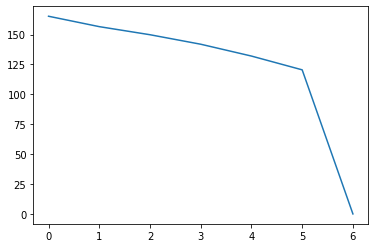

In [177]:
T = 7

losses = []
for r in voronoi.radar:
    gt = df[df.radar==r].vid.to_numpy()
    mlp = df[df.radar==r].mlp.to_numpy()
    gt = np.stack([gt[night[:T]] for night in nights])
    mlp = np.stack([mlp[night[:T]] for night in nights])
    losses.append(np.square(gt - mlp))
rmse = np.sqrt(np.concatenate(losses, axis=0).mean(0))
plt.plot(rmse)

ValueError: x and y must be the same size

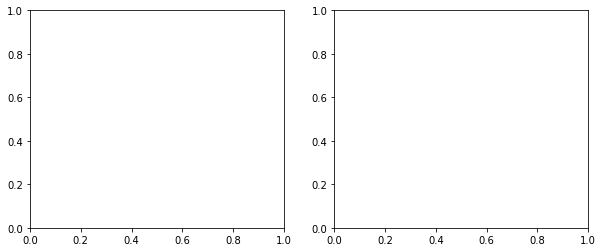

In [219]:
max_flux = max(ml_fluxes.max(), abm_fluxes.max())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))    
ax[0].scatter(abm_fluxes.flatten(), ml_fluxes.flatten(), alpha=0.2)
ax[1].scatter(abm_fluxes.flatten(), ml_fluxes.flatten(), alpha=0.2)
ax[0].plot(range(int(max_flux)), range(int(max_flux)), ls='--', c='gray')
ax[1].plot(range(int(max_flux)), range(int(max_flux)), ls='--', c='gray')
ax[0].set(title='linear scale', xlabel='true (simulated) flux', ylabel='inferred flux')#, xlim=(0-margin,max_flux_boundary+margin), ylim=(0-margin,max_flux_boundary+margin))
ax[1].set(title='loglog scale', xlabel='true (simulated) flux')#, xlim=(0-margin,max_flux_inner+margin), ylim=(0-margin,max_flux_inner+margin));
ax[1].set(yscale='symlog', xscale='symlog');

Text(0.5, 0, 'true (simulated) flux')

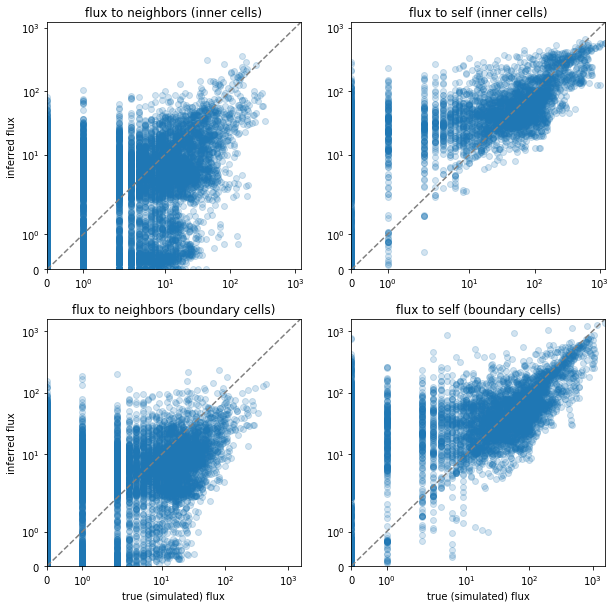

In [216]:
boundary_idx = voronoi.index[voronoi['boundary'] == 1]
inner_idx = voronoi.index[voronoi['boundary'] == 0]

fig, ax = plt.subplots(2, 2, figsize=(10, 10)) 
for idx, cell_type in enumerate(['inner cells', 'boundary cells']):
    cell_idx = voronoi.index[voronoi['boundary'] == idx]
    self_flows_abm = []
    self_flows_ml = []
    other_flows_abm = abm_fluxes.copy()
    other_flows_ml = ml_fluxes.copy()
    for r, name in enumerate(voronoi.radar.to_numpy()):
        if r in cell_idx:
            self_flows_abm.extend(abm_fluxes[r,r])
            self_flows_ml.extend(ml_fluxes[r,r])
        other_flows_abm[r,r] = np.nan
        other_flows_ml[r, r] = np.nan
    other_flows_abm = other_flows_abm[cell_idx]
    other_flows_ml = other_flows_ml[cell_idx]

    ax[idx, 0].scatter(other_flows_abm.flatten(), other_flows_ml.flatten(), alpha=0.2)
    ax[idx, 0].plot(range(int(max_flux)), range(int(max_flux)), ls='--', c='gray')
    ax[idx, 1].scatter(self_flows_abm, self_flows_ml, alpha=0.2)
    ax[idx, 1].plot(range(int(max_flux)), range(int(max_flux)), ls='--', c='gray')
    max_flux_cells = max(ml_fluxes[cell_idx].max(), abm_fluxes[cell_idx].max())
    ax[idx, 0].set(title=f'flux to neighbors ({cell_type})', ylabel='inferred flux', xlim=(0,max_flux_cells), ylim=(0,max_flux_cells))
    ax[idx, 1].set(title=f'flux to self ({cell_type})', xlim=(0,max_flux_cells), ylim=(0,max_flux_cells))
    ax[idx, 0].set(yscale='symlog', xscale='symlog')
    ax[idx, 1].set(yscale='symlog', xscale='symlog')
ax[1,0].set_xlabel('true (simulated) flux')
ax[1,1].set_xlabel('true (simulated) flux');


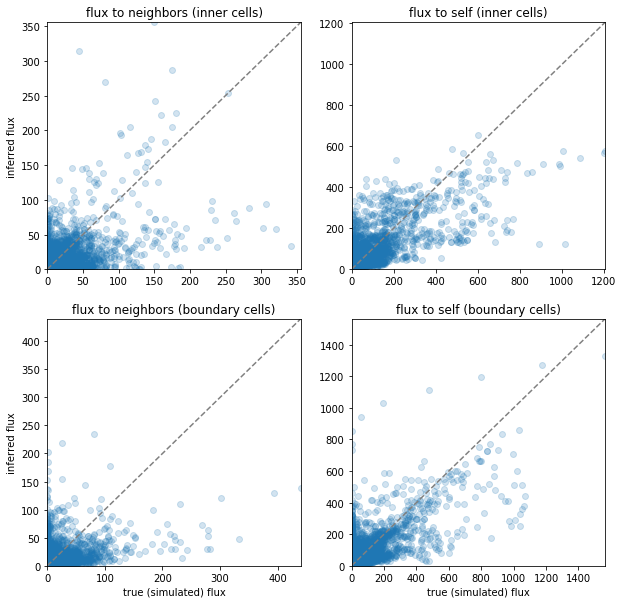

In [214]:
boundary_idx = voronoi.index[voronoi['boundary'] == 1]
inner_idx = voronoi.index[voronoi['boundary'] == 0]

fig, ax = plt.subplots(2, 2, figsize=(10, 10)) 
for idx, cell_type in enumerate(['inner cells', 'boundary cells']):
    cell_idx = voronoi.index[voronoi['boundary'] == idx]
    self_flows_abm = []
    self_flows_ml = []
    other_flows_abm = abm_fluxes.copy()
    other_flows_ml = ml_fluxes.copy()
    for r, name in enumerate(voronoi.radar.to_numpy()):
        if r in cell_idx:
            self_flows_abm.extend(abm_fluxes[r,r])
            self_flows_ml.extend(ml_fluxes[r,r])
        other_flows_abm[r,r] = np.nan
        other_flows_ml[r, r] = np.nan
    other_flows_abm = other_flows_abm[cell_idx]
    other_flows_ml = other_flows_ml[cell_idx]

    ax[idx, 0].scatter(other_flows_abm.flatten(), other_flows_ml.flatten(), alpha=0.2)
    ax[idx, 0].plot(range(int(max_flux)), range(int(max_flux)), ls='--', c='gray')
    ax[idx, 1].scatter(self_flows_abm, self_flows_ml, alpha=0.2)
    ax[idx, 1].plot(range(int(max_flux)), range(int(max_flux)), ls='--', c='gray')
    max_flux_cells = max(np.nanmax(other_flows_abm), np.nanmax(other_flows_ml))
    ax[idx, 0].set(title=f'flux to neighbors ({cell_type})', ylabel='inferred flux', xlim=(0,max_flux_cells), ylim=(0,max_flux_cells))
    max_flux_cells = max(max(self_flows_abm), max(self_flows_ml))
    ax[idx, 1].set(title=f'flux to self ({cell_type})', xlim=(0,max_flux_cells), ylim=(0,max_flux_cells))
ax[1,0].set_xlabel('true (simulated) flux')
ax[1,1].set_xlabel('true (simulated) flux');

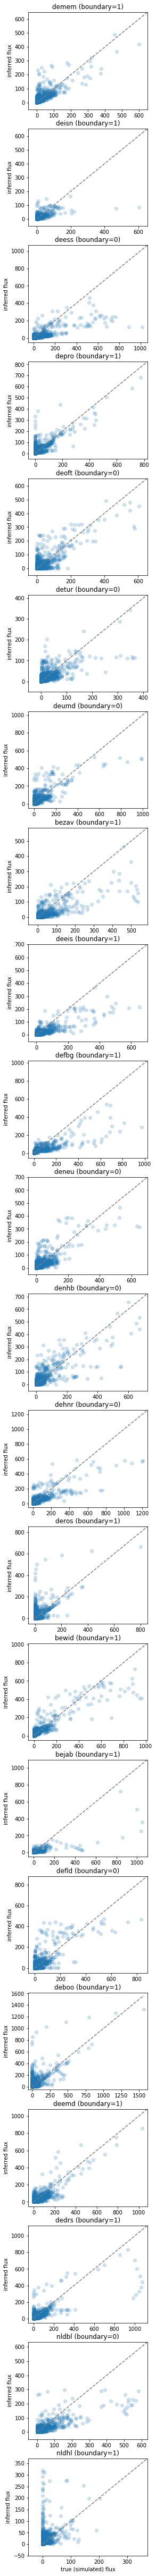

In [217]:
margin=50
fig, ax = plt.subplots(len(radar_index), figsize=(4, len(radar_index)*4))
for ridx, name in enumerate(voronoi.radar):
    ax[ridx].scatter(abm_fluxes[ridx].flatten(), ml_fluxes[ridx].flatten(), alpha=0.2)
    ax[ridx].plot(range(int(max_flux)), range(int(max_flux)), ls='--', c='gray')
    margin=50
    max_flux_r = max(abm_fluxes[ridx].max(), ml_fluxes[ridx].max())
    ax[ridx].set(ylabel='inferred flux', xlim=(0-margin,max_flux_r+margin), ylim=(0-margin,max_flux_r+margin))
    ax[ridx].set(title=f'{name} (boundary={voronoi["boundary"][ridx]})')
    
ax[-1].set(xlabel='true (simulated) flux') 
#fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

In [74]:
for idx, radar in enumerate(voronoi.radar):
    print(f'outflux for radar {radar}')
    idx_fluxes = torch.cat([night_fluxes[idx, :, :] for night_fluxes in outfluxes.values()], dim=-1)
    mean_fluxes = idx_fluxes.mean(-1).detach().numpy()
    std_fluxes = idx_fluxes.std(-1).detach().numpy()
    
    total = 0
    for jdx, flux in enumerate(mean_fluxes):
        if flux > 0:
            total += flux
            print(voronoi.radar.iloc[jdx], flux, '+/-', std_fluxes[jdx])
    print(f'total mean flux: {total} \n')
#outfluxes

outflux for radar DE/MEM
DE/MEM 0.7340218 +/- 0.05989632
DE/ISN 7.744116e-06 +/- 3.528815e-05
DE/TUR 8.916785e-12 +/- 4.610178e-11
DE/FBG 0.088997215 +/- 0.032579485
total mean flux: 0.8230267420329292 

outflux for radar DE/ISN
DE/MEM 0.12885828 +/- 0.04236835
DE/ISN 0.7244413 +/- 0.060366992
DE/TUR 9.367423e-14 +/- 5.6486125e-13
DE/EIS 1.4875012e-10 +/- 8.9679797e-10
total mean flux: 0.8532995732126942 

outflux for radar DE/ESS
DE/ESS 0.6964356 +/- 0.09002142
DE/OFT 0.043886308 +/- 0.054031156
BE/ZAV 0.08268854 +/- 0.023282286
DE/NHB 0.18108179 +/- 0.09754337
DE/HNR 5.7433044e-06 +/- 4.6147466e-05
DE/FLD 0.004594321 +/- 0.01236901
DE/EMD 4.2042977e-08 +/- 4.6097122e-07
NL/DBL 1.2580154e-09 +/- 1.37934e-08
total mean flux: 1.0086923128182614 

outflux for radar DE/PRO
DE/PRO 0.6997376 +/- 0.092436925
DE/UMD 0.0950667 +/- 0.026283493
DE/ROS 1.65752e-11 +/- 6.1992994e-11
DE/DRS 0.16911854 +/- 0.09338165
total mean flux: 0.9639228433536342 

outflux for radar DE/OFT
DE/ESS 7.8267476e-11